In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import numpy as np
from tqdm import tqdm
from plotManager import plotManager
DATASET_PATH = "./data/2_bike_rental_dataset_preprocessed.csv"

In [35]:
!pip install tqdm

     |████████████████████████████████| 78 kB 2.4 MB/s eta 0:00:01
You should consider upgrading via the '/Users/edoardomorucci/PycharmProjects/bike-rental-demand-prediction/venv/bin/python -m pip install --upgrade pip' command.


In [20]:
def print_evaluation(y_test, y_pred):
    print("Mean absolute error: " + str(metrics.mean_absolute_error(y_test, y_pred)))
    print("Mean squared error: " + str(metrics.mean_squared_error(y_test, y_pred)))
    print("Root mean square error: " + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    print("Mean absolute percentage error: " + str(metrics.mean_absolute_percentage_error(y_test, y_pred)))
    print("Max error: " + str(metrics.max_error(y_test, y_pred)))

## Create train and test datasets

In [21]:
df = pd.read_csv(DATASET_PATH, index_col="date", parse_dates=True)
df.head()
columns = df.columns
columns = columns.drop("rentals")
columns = columns.drop("instant")

print(columns)
X = df[columns]
y = df["rentals"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=20, shuffle=False)

Index(['year', 'workingday', 'temp', 'humidity', 'windspeed', 'season_1',
       'season_2', 'season_3', 'season_4', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'weather_1', 'weather_2',
       'weather_3', 'weather_4', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')


In [22]:
regressor_random_forest = RandomForestRegressor(n_estimators=10, random_state=0)
regressor_random_forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [23]:
y_pred = regressor_random_forest.predict(X_test)
y_pred

array([ 82.9, 101. ,  14. , ..., 124.5,  87.2,  48.7])

In [24]:
print_evaluation(y_test, y_pred)

Final Model
Mean absolute error: 52.56407706305879
Mean squared error: 5995.174146481789
Root mean square error: 77.42850990740935
Mean absolute percentage error: 0.47594484534005166
Max error: 450.5


# Searching for optimal hyperparameters

The first trial in searching the optimal hyperparameters is using the RandomizedSearchCV, however this technique does not respect the temporal constraint because shuffles data. Later on we will tune the hyperparameters using a custom approach simply iterating different parameters with some nested for loop, in this case we are sure that the temporal constraint is respected.

In [25]:
n_estimators = [x for x in range(10,300,30)]
max_depth = [x for x in range(10,200,30)]
min_samples_split = [2, 5, 10, 20]
min_samples_leaf = [1, 2, 4, 8]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 40, 70, 100, 130, 160, 190, 220, 250, 280], 'max_depth': [10, 40, 70, 100, 130, 160, 190], 'min_samples_split': [2, 5, 10, 20], 'min_samples_leaf': [1, 2, 4, 8], 'bootstrap': [True, False]}


In [26]:
rf_base = RandomForestRegressor()
random_forest_random = RandomizedSearchCV(estimator = rf_base, param_distributions=random_grid, n_iter=10)
random_forest_random.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 40, 70, 100, 130, 160,
                                                      190],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [10, 40, 70, 100, 130,
                                                         160, 190, 220, 250,
                                                         280]})

In [29]:
random_forest_random.best_params_

{'n_estimators': 160,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 40,
 'bootstrap': True}

## Custom hyperparameters tuning

In [39]:
n_estimators = [x for x in range(10,100,20)]
max_depth = [x for x in range(10,100,20)]
min_samples_split = [2, 5, 10, 20]
min_samples_leaf = [1, 2, 4, 8]
bootstrap = [True, False]
print(n_estimators)
print(max_depth)


[10, 30, 50, 70, 90]
[10, 30, 50, 70, 90]


In [43]:
min_error = 100
best_n_est = 0
best_max_depth = 0
best_min_split = 0
best_min_leaf = 0
best_boot = False

for n_estimator in tqdm(n_estimators):
    for max_dep in max_depth:
        for min_s_split in min_samples_split:
            for min_s_leaf in min_samples_split:
                for bool in bootstrap:

                    regressor_random_forest = RandomForestRegressor(n_estimators=n_estimator, min_samples_split=min_s_split, min_samples_leaf=min_s_leaf, max_depth=max_dep ,random_state = 10, bootstrap=bool)
                    regressor_random_forest.fit(X_train, y_train)
                    y_pred = regressor_random_forest.predict(X_test)

                    mae = metrics.mean_absolute_error(y_test, y_pred)
                    if mae < min_error:
                        min_error = mae
                        best_n_est = n_estimator
                        best_max_depth = max_dep
                        best_min_split = min_s_split
                        best_min_leaf = min_s_leaf
                        best_boot = bool

100%|██████████| 5/5 [27:08<00:00, 325.63s/it]


In [52]:
print("Best parameters: " + "\n" +
        "n_estimators: " + str(best_n_est) +"\n" +
        "max_depth: " + str(best_max_depth) +"\n" +
        "min_samples_split: " + str(best_min_split) +"\n" +
        "min_samples_leaf: " + str(best_min_leaf) +"\n" +
        "bootstrap: " + str(best_boot)
      )

Best parameters: 
n_estimators: 90
max_depth: 50
min_samples_split: 5
min_samples_leaf: 2
bootstrap: True


# Random Forest Model using Best Parameters

In [46]:
random_forest_opt = RandomForestRegressor(n_estimators=90, min_samples_split=5, min_samples_leaf=2, max_depth=50 ,random_state = 10, bootstrap=True)
random_forest_opt.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=90, random_state=10)

In [47]:
y_pred = random_forest_opt.predict(X_test)
y_pred

array([ 75.30441358,  52.80316138,  13.71910935, ..., 103.13833774,
        93.49766314,  52.29283349])

## Performance Evaluation

In [49]:
print_evaluation(y_test, y_pred)

Final Model
Mean absolute error: 51.5999084903662
Mean squared error: 5643.4977880561455
Root mean square error: 75.12321737023878
Mean absolute percentage error: 0.5106618967348157
Max error: 429.1515520282187


## Prediction Result

In [50]:
new_df=y_test.copy()
new_df = new_df.to_frame()
new_df['predicted_rentals'] = y_pred
new_df = new_df.sort_index()
new_df

,rentals,predicted_rentals
date,,
2012-06-24 03:00:00,60,75.304414
2012-06-24 04:00:00,13,52.803161
2012-06-24 05:00:00,8,13.719109
2012-06-24 06:00:00,25,73.050595
2012-06-24 07:00:00,71,109.790450
...,...,...
2012-12-31 19:00:00,119,189.131252
2012-12-31 20:00:00,89,149.623211
2012-12-31 21:00:00,90,103.138338


In [15]:
%run plotManager.py

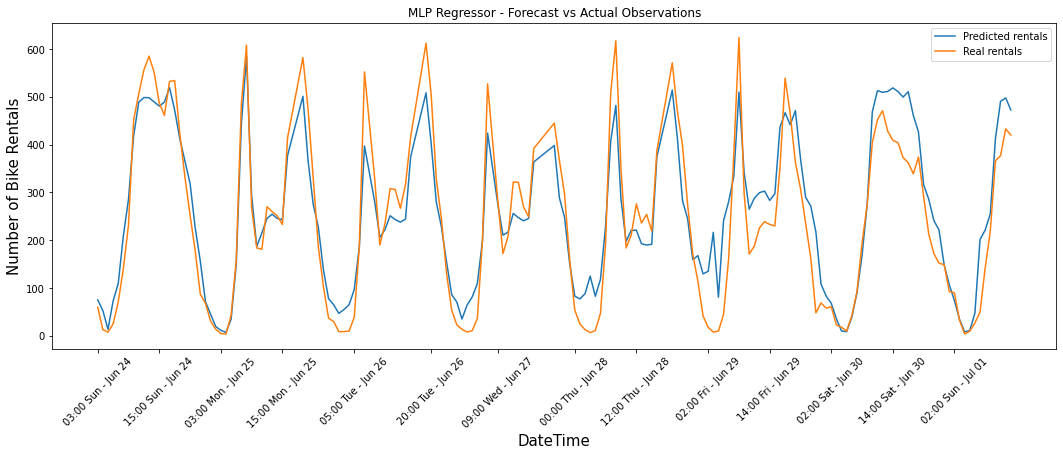

In [51]:
plotMan = plotManager(new_df)
plotMan.forecast_plot(new_df)